Importing required packages

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix
import time as t
from sklearn.neural_network import MLPClassifier

In [ ]:
import numpy as np
import struct
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
import matplotlib.pyplot as plt


# Loading ubyte files
def load_ubyte_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))  # Read the header
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)

def load_ubyte_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))  # Read the header
        return np.frombuffer(f.read(), dtype=np.uint8)

# Update file paths to the correct location
X_train = load_ubyte_images(r"D:\CMI\DMML\archive (2)\train-images-idx3-ubyte")
y_train = load_ubyte_labels(r"D:\CMI\DMML\archive (2)\train-labels-idx1-ubyte")
X_test = load_ubyte_images(r"D:\CMI\DMML\archive (2)\test-images-idx3-ubyte")
y_test = load_ubyte_labels(r"D:\CMI\DMML\archive (2)\test-labels-idx1-ubyte")

# Verify the shapes of the loaded data
print("Training Images Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Test Images Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)


Training Images Shape: (8519, 28, 28)
Training Labels Shape: (8519,)
Test Images Shape: (1065, 28, 28)
Test Labels Shape: (1065,)


Plotting each class in the dataset

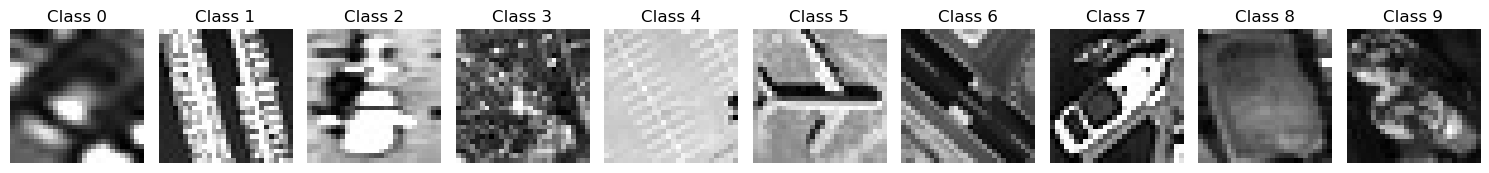

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
num_classes = 10

# Set up a grid of subplots for visualization
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))  # One row, num_classes columns
axes = axes.flatten()

# Loop through each class and plot one image
for class_id in range(num_classes):
    # Get the indices of images corresponding to this class
    class_indices = np.where(y_train == class_id)[0]

    # Select the first image from the class (or randomly, if you prefer)
    selected_index = class_indices[0]

    # Plot the image
    ax = axes[class_id]
    ax.imshow(X_train[selected_index].reshape(28, 28), cmap='gray')  # Adjust shape if necessary
    ax.axis('off')
    ax.set_title(f'Class {class_id}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Flattening and scaling the dataset
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)



Clusters the training data into k clusters using the K-Means algorithm.


In [ ]:
def cluster_data(X_train_flat, k):
    # Cluster into k clusters using KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    X_train_dist = kmeans.fit_transform(X_train_flat)

    return kmeans, X_train_dist

Selects one representative image for each cluster — specifically, the image closest to each cluster center.


In [ ]:
def identify_representative_images(X_train_flat, X_train_dist, kmeans):
    # Identify 1 representative image per cluster
    rep_idx = np.argmin(X_train_dist, axis=0)  # closest points to the centroid
    X_reps = X_train_flat[rep_idx]
    y_reps = y_train[rep_idx]

    return X_reps, y_reps

To visualize one representative image per cluster, helping to interpret and manually label what each cluster represents.



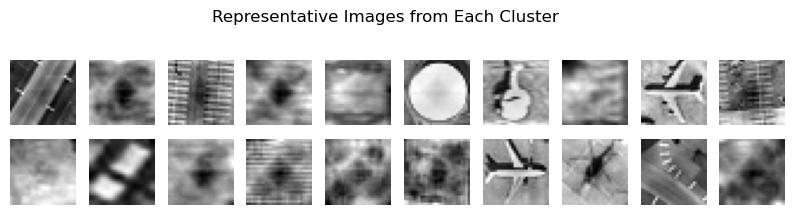

In [ ]:
# Visualize representative images
kmeans,X_train_dist=cluster_data(X_train_flat,20)
X_reps,y_reps=identify_representative_images(X_train_flat,X_train_dist,kmeans)
plt.figure(figsize=(10, 5))
for i, img in enumerate(X_reps):
    plt.subplot(5, 10, i+1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Representative Images from Each Cluster")
plt.show()




Train a simple Logistic Regression model using only the representative samples from each cluster instead of the full dataset.



In [ ]:
from sklearn.linear_model import LogisticRegression

def train_on_representatives(X_train_flat,k):
    kmeans,X_train_dist=cluster_data(X_train_flat,k)
    X_reps,y_reps=identify_representative_images(X_train_flat,X_train_dist,kmeans)

    clf = LogisticRegression(max_iter=3000, solver='saga') # Using 'saga' solver for larger datasets
    clf.fit(X_reps, y_reps)

    return clf


In [ ]:
# Assuming X_train_flat is your flattened training data and k is the number of clusters
clf = train_on_representatives(X_train_flat, k=50)

# You can now evaluate this model using your test set
accuracy = clf.score(X_test_flat, y_test)
print(f"Accuracy using only representative images: {accuracy}")


Accuracy using only representative images: 0.2300469483568075


D:\soft\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Full label propagation - The representative labels from the clusters are used to propagate labels across the entire dataset, and then a classifier is trained on this pseudo-labeled data.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode
import numpy as np

def semi_supervised_kmeans_full(X_train_flat, y_train, X_test_flat, y_test, k):
    # Step 1: Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_flat)

    # Step 2: Assign representative labels to clusters
    y_reps = np.zeros(k, dtype=int)
    for i in range(k):
        cluster_idxs = np.where(kmeans.labels_ == i)[0]
        cluster_labels = y_train[cluster_idxs]
        if len(cluster_labels) > 0:
            y_reps[i] = mode(cluster_labels, keepdims=True).mode[0]
        else:
            y_reps[i] = -1  # unknown label

    # Step 3: Propagate labels to all points
    y_train_prop = np.array([y_reps[label] for label in kmeans.labels_])

    # Step 4: Train on full cluster-labeled data
    clf_full = LogisticRegression(max_iter=3000, solver='saga')
    clf_full.fit(X_train_flat, y_train_prop)
    acc_full = clf_full.score(X_test_flat, y_test)
    return acc_full





In [ ]:
# Example usage:
k_value = 50  # you can set this to any value you want
acc = semi_supervised_kmeans_full(X_train_flat, y_train, X_test_flat, y_test, k=k_value)
print(f"[k={k_value}] Full Propagation Accuracy: {acc:.4f}")


[k=50] Full Propagation Accuracy: 0.4535


Partial propagation - Assigning representative labels to each cluster, and then selecting the top X% closest points from each cluster to train a classifier.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode
import numpy as np

def semi_supervised_kmeans(X_train_flat, y_train, X_test_flat, y_test, k, top_percent=20):
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_flat)

    # Assign representative labels to clusters
    y_reps = np.zeros(k, dtype=int)
    for i in range(k):
        cluster_idxs = np.where(kmeans.labels_ == i)[0]
        cluster_labels = y_train[cluster_idxs]
        if len(cluster_labels) > 0:
            y_reps[i] = mode(cluster_labels, keepdims=True).mode[0]
        else:
            y_reps[i] = -1  # unknown label

    # Propagate labels to all points
    y_train_prop = np.array([y_reps[label] for label in kmeans.labels_])


    # Compute distances to cluster centers
    dists = np.linalg.norm(X_train_flat - kmeans.cluster_centers_[kmeans.labels_], axis=1)

    # Select top X% closest points per cluster
    mask = np.zeros(len(X_train_flat), dtype=bool)
    for i in range(k):
        cluster_idxs = np.where(kmeans.labels_ == i)[0]
        cluster_dists = dists[cluster_idxs]
        cutoff = np.percentile(cluster_dists, top_percent)
        close_idxs = cluster_idxs[cluster_dists <= cutoff]
        mask[close_idxs] = True

    X_selected = X_train_flat[mask]
    y_selected = y_train_prop[mask]

    # Train on top X% of each cluster
    clf_partial = LogisticRegression(max_iter=3000, solver='saga')
    clf_partial.fit(X_selected, y_selected)
    acc_partial = clf_partial.score(X_test_flat, y_test)

    return acc_partial




for k = 20
[k=20] Completed in 740.25 seconds
    Top 20% Accuracy : 0.4413

for k = 30
[k=30] Completed in 439.52 seconds
    Top 20% Accuracy : 0.4498

for k = 40
[k=40] Completed in 319.22 seconds
    Top 20% Accuracy : 0.4554

for k = 50


D:\soft\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[k=50] Completed in 394.86 seconds
    Top 20% Accuracy : 0.4526

for k = 60
[k=60] Completed in 200.28 seconds
    Top 20% Accuracy : 0.3700

for k = 70
[k=70] Completed in 241.60 seconds
    Top 20% Accuracy : 0.4188

for k = 80
[k=80] Completed in 394.32 seconds
    Top 20% Accuracy : 0.4413

for k = 90
[k=90] Completed in 219.74 seconds
    Top 20% Accuracy : 0.4394

for k = 100
[k=100] Completed in 262.73 seconds
    Top 20% Accuracy : 0.4451

All runs completed!



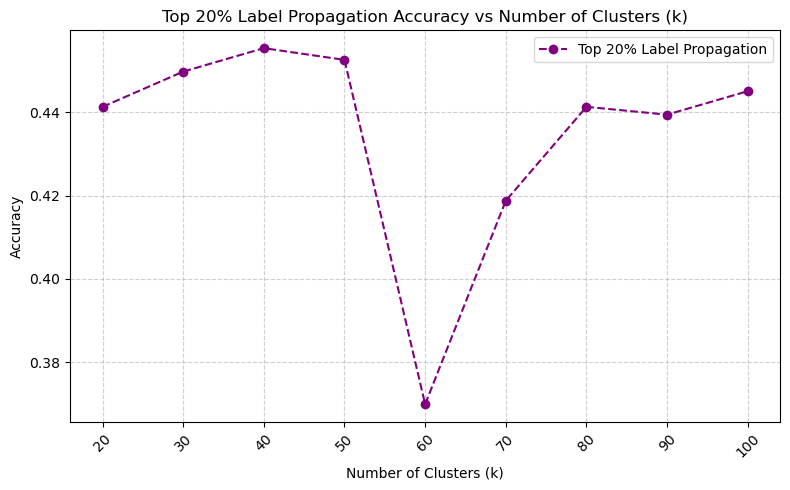

In [ ]:
import time
import matplotlib.pyplot as plt

# Define different cluster counts to try
k_values = [20, 30, 40, 50, 60, 70,  80, 90, 100]
results = {}


# Loop through each value of k and record performance
for k in k_values:
    print(f"for k = {k}")
    start_time = time.time()

    # Call your custom semi-supervised k-means function
    acc_partial = semi_supervised_kmeans(
        X_train_flat, y_train, X_test_flat, y_test, k=k, top_percent=20
    )

    elapsed = time.time() - start_time
    print(f"[k={k}] Completed in {elapsed:.2f} seconds")
    print(f"    Top 20% Accuracy : {acc_partial:.4f}\n")

    # Save results for plotting
    results[k] = {'partial': acc_partial}

print("All runs completed!\n")

# Extract values for plotting
k_vals = list(results.keys())
partial_accs = [results[k]['partial'] for k in k_vals]

# Plot the performance vs number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_vals, partial_accs, marker='o', linestyle='--', color='purple', label='Top 20% Label Propagation')

plt.title("Top 20% Label Propagation Accuracy vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Accuracy")
plt.xticks(k_vals, rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### MLP MODEL


The function propagates labels from the most frequent labels of cluster representatives to a selected portion of points within each cluster based on their proximity to the cluster's center. Only a subset (defined by propagation_percentage) of points closest to the cluster's center are labeled, and the rest remain unlabeled.


In [ ]:
def propagate_labels_partially(X_train_flat, X_train_dist, y_train, kmeans, k, propagation_percentage):
    # Compute distance of each point to its assigned cluster center
    dists = np.linalg.norm(X_train_flat - kmeans.cluster_centers_[kmeans.labels_], axis=1)

    # Initialize labels with dummy value (-1 means unlabeled)
    y_train_prop = np.full(len(X_train_flat), -1, dtype=np.int32)

    for i in range(k):
        # Find indices of points assigned to cluster i
        cluster_idxs = np.where(kmeans.labels_ == i)[0]
        if len(cluster_idxs) == 0:
            continue  # skip empty cluster

        # Get distances of these points to their cluster center
        cluster_dists = dists[cluster_idxs]

        # Select top X% closest points
        cutoff = np.percentile(cluster_dists, propagation_percentage * 100)
        close_idxs = cluster_idxs[cluster_dists <= cutoff]

        # Assign most frequent label in cluster to those close points
        cluster_labels = y_train[cluster_idxs]
        most_common_label = np.bincount(cluster_labels).argmax()
        y_train_prop[close_idxs] = most_common_label

    return y_train_prop


In [ ]:
# Train the MLP Classifier
def train_mlp_classifier(X_train_flat, y_train, X_val, y_val, k, propagation, rnd_st=42, ):
    # Perform clustering
    kmeans, X_train_dist = cluster_data(X_train_flat, k)

    # Identify the representative images
    X_reps, y_reps = identify_representative_images(X_train_flat, X_train_dist, kmeans)

    # Propagate labels partially (only 20% of data will get labeled)
    y_train_prop = propagate_labels_partially(X_train_flat, X_train_dist, y_train, kmeans,k, propagation)

    # Filter out only the points that got labels (i.e., label ≠ 0 or a dummy value)
    labeled_indices = y_train_prop > 0  # Adjust if 0 is a valid label

    # Get corresponding X and y
    X_train_labeled = X_train_flat[labeled_indices]
    y_train_labeled = y_train_prop[labeled_indices]

    # Instantiate and train the MLPClassifier
    mlp = MLPClassifier(random_state=rnd_st, max_iter=500,solver='adam')

    st = t.time()
    mlp.fit(X_train_labeled, y_train_labeled)
    elapsed_time = t.time() - st

    # Make predictions on validation data
    y_pred = mlp.predict(X_val)

    # Evaluate performance using regular label vectors
    acc = accuracy_score(y_val, y_pred)
    mlp_rpt = classification_report(y_val, y_pred, output_dict=True, zero_division=1)
    conf = multilabel_confusion_matrix(y_val, y_pred)

    # Save results
    mlp_results = pd.DataFrame(mlp_rpt).T
    print(f'Accuracy: {acc:.4f}\n\nClassification Report:\n{mlp_results}')
    print(f"Training Time: {elapsed_time:.2f} seconds")

    return mlp, acc, mlp_rpt, conf


Propagating for top 20% closest point


--- Training with k = 5 ---
Accuracy: 0.2385

Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.000000  0.000000   112.000000
1              0.196262  0.567568  0.291667   111.000000
2              1.000000  0.000000  0.000000    82.000000
3              0.195584  0.563636  0.290398   110.000000
4              1.000000  0.000000  0.000000   112.000000
5              0.358209  0.648649  0.461538   111.000000
6              0.252212  0.570000  0.349693   100.000000
7              1.000000  0.000000  0.000000   111.000000
8              1.000000  0.000000  0.000000   105.000000
9              1.000000  0.000000  0.000000   111.000000
accuracy       0.238498  0.238498  0.238498     0.238498
macro avg      0.700227  0.234985  0.139330  1065.000000
weighted avg   0.696039  0.238498  0.141332  1065.000000
Training Time: 11.23 seconds

--- Training with k = 15 ---
Accuracy: 0.3709

Classification Report:
              precision    recal

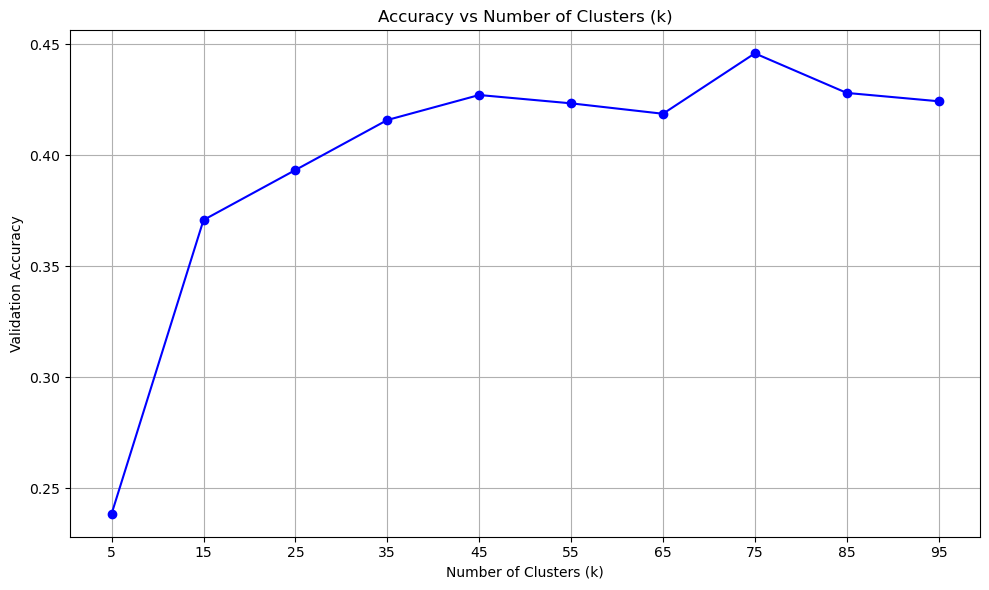

In [ ]:
import matplotlib.pyplot as plt

# Define the range of k values to test
k_values = list(range(5, 100, 10))  # You can change the range as needed
accuracies = []

for k in k_values:
    print(f"\n--- Training with k = {k} ---")
    mlp_model, acc, _, _ = train_mlp_classifier(X_train_flat, y_train, X_test_flat, y_test, k, 0.2)
    accuracies.append(acc)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Accuracy vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


Propagating for top 30% closest point


--- Training with k = 5 ---
Accuracy: 0.2310

Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.000000  0.000000   112.000000
1              0.198473  0.468468  0.278820   111.000000
2              1.000000  0.000000  0.000000    82.000000
3              0.185535  0.536364  0.275701   110.000000
4              1.000000  0.000000  0.000000   112.000000
5              0.356021  0.612613  0.450331   111.000000
6              0.227891  0.670000  0.340102   100.000000
7              1.000000  0.000000  0.000000   111.000000
8              1.000000  0.000000  0.000000   105.000000
9              1.000000  0.000000  0.000000   111.000000
accuracy       0.230986  0.230986  0.230986     0.230986
macro avg      0.696792  0.228744  0.134495  1065.000000
weighted avg   0.692720  0.230986  0.136407  1065.000000
Training Time: 14.89 seconds

--- Training with k = 15 ---
Accuracy: 0.3746

Classification Report:
              precision    recal

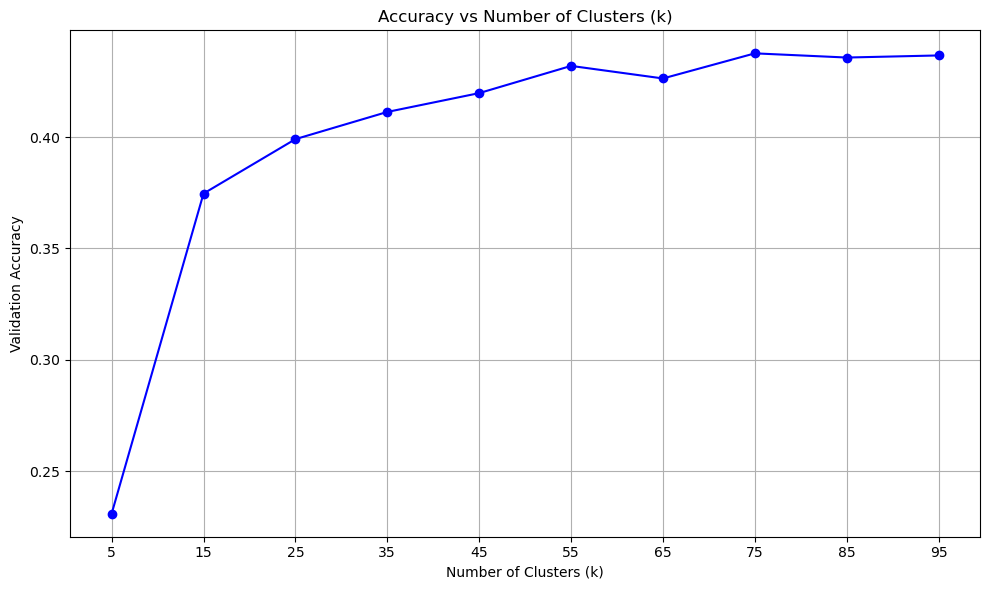

In [ ]:
import matplotlib.pyplot as plt

# Define the range of k values to test
k_values = list(range(5, 100, 10))  # You can change the range as needed
accuracies = []

for k in k_values:
    print(f"\n--- Training with k = {k} ---")
    mlp_model, acc, _, _ = train_mlp_classifier(X_train_flat, y_train, X_test_flat, y_test, k, 0.3)
    accuracies.append(acc)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Accuracy vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()
